# External catolog queries: 

This notbook will demonstrate how to query catalogs using the CatalogQuery class. Each instance of this class
has to be connected to (and search in) a specific catalog and collection. Once the instance is created it provides methods to query for:

   - all the sources with a certain distance.
   - closest source at a given position.
   - binary search: return yes/no if anything is around the positon.
   - user defined queries.

In all cases the results of the queries will be return an astropy.table.Table object (this can be dsiabled in the last case, the user-defined query). The first item on the above list (search within a given radius) provides the basic block for the other two types of position-matching queries (the closest match and the binary search). It is implemented in three different ways:

- using healpix: if the catalog sources have been assigned an healpix index, the search first returns the sources in the 9 healpix close to the target position (the central one + 8 neighbours)
- using geoJSON/legacy coordinates: if the catalog documents have the position arranged in one of these two formats, the query is based on the `geoWithin` and `centerSphere` mongo filters. 
- raw: this method uses the `where` keyword to evaluate a javascript function on each document. This function computes the distance of the point to the target and compares it to the search radius. This method does not require any additional field to be added to the catalog.

These core functions are defined in the catquery_utils module. 

Here below the different queries will be run using a set points uniformly distributed on a sphere. The performances of the different methods will be compared. 

In [1]:
from extcats import CatalogQuery

# initialize the CatalogQuery object pointing it to an existsing database
mqc_query = CatalogQuery.CatalogQuery(
    cat_name="milliquas",  # name of the database
    coll_name="srcs",  # name of the collection with the sources
    dbclient=None,
)


# specify target position (same format as the 'ra_key' and
# 'dec_key specified at initilization) and serach radius
target_ra, target_dec, rs = 5.458082, 16.035756, 100.0
target_ra, target_dec, rs = 321.6639722, -89.48325, 100.0

INFO:extcats.CatalogQuery:using mongo client at localhost:27017
INFO:extcats.CatalogQuery:connected to collection srcs of database milliquas.
INFO:extcats.CatalogQuery:found 1998464 documents in source collection srcs.
INFO:extcats.CatalogQuery:set HEALPIX partition of order 16 with key 'hpxid_16'. Nested: True, Indexed: True, Resolution ["]: 3.221
INFO:extcats.CatalogQuery:set 2dsphere key 'pos' with format geoJSON. Indexed: True
INFO:extcats.CatalogQuery:source collection has the following indexes: _id, hpxid_16, pos
INFO:extcats.CatalogQuery:setting default search method to '2dsphere'


## example queries: all sources within a given radius from target

In the following cell we illustrate the three search methods implemented in CatalogQuery and how they
are applied to the basic search pattern: retrieve all the sources within a given radius from the specified position.

**IMPORTANT:** when using the HEALPIX method, the natural query does not return results in a circle, but rather in a square-like pattern of HEALpixels that covers the search radius. By default the matches are then skimmed for sources outside the circular search radius. Use pass circular = False to the query functions to disable this behaviour.

1 sources found around target position using the 'raw' method.
1 sources found around target position using the '2dsphere' method.
1 sources found around target position using the 'healpix' method.
1 sources found around target position using the 'healpix' (square) method.


<IPython.core.display.Javascript object>


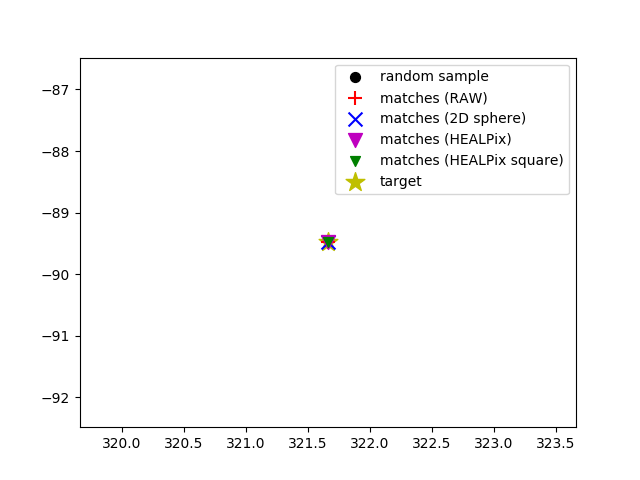

In [2]:
# the 'raw' method does not require any pre-formatting of the catalog.
# It first selects points within a box of radius 'box_scale' times larger than the
# search radius using $gte and $lte operators, then uses the $where expression
# to compute the angular distance of the sources in the box from the target.
out_raw = mqc_query.findwithin(target_ra, target_dec, rs, method="raw", box_scale=2.5)
if not out_raw is None:
    print(
        "%d sources found around target position using the 'raw' method." % len(out_raw)
    )

# the '2dsphere' method uses instead the use mongodb searches in
# spherical geometry using "$geoWithin" and "$centerSphere" operators.
# it requires the catalog documents to have been assigned a geoJSON
# or 'legacy pair' field of type 'Point' (see insert_example notebook).
out_2dsphere = mqc_query.findwithin(target_ra, target_dec, rs, method="2dsphere")
if not out_2dsphere is None:
    print(
        "%d sources found around target position using the '2dsphere' method."
        % len(out_2dsphere)
    )


# finally, the healpix method can be used to speed up queries using a
# spatial prepartinioning of the data based on a HEALPix grid. In this
# case, the sources in the catalog should be assigned a field containing
# the ID of the healpix that contains it.
out_healpix = mqc_query.findwithin(target_ra, target_dec, rs, method="healpix")
if not out_healpix is None:
    print(
        "%d sources found around target position using the 'healpix' method."
        % len(out_healpix)
    )

out_healpix_square = mqc_query.findwithin(
    target_ra, target_dec, rs, method="healpix", circular=False
)
if not out_healpix_square is None:
    print(
        "%d sources found around target position using the 'healpix' (square) method."
        % len(out_healpix_square)
    )


# ======================================== #
#    make a plot with the query results    #
# ======================================== #
%matplotlib notebook
import matplotlib.pyplot as plt

# get a random sample from the catalog
cat_pos = [
    [o["ra"], o["dec"]]
    for o in mqc_query.src_coll.aggregate([{"$sample": {"size": 5000}}])
]
cat_ra, cat_dec = zip(*cat_pos)


fig = plt.figure()
ax = fig.add_subplot(111)  # , projection="aitoff")

ax.scatter(cat_ra, cat_dec, label="random sample", c="k", s=50, marker="o", zorder=1)
ax.scatter(
    out_raw["ra"], out_raw["dec"], label="matches (RAW)", c="r", s=100, marker="+"
)
ax.scatter(
    out_2dsphere["ra"],
    out_2dsphere["dec"],
    label="matches (2D sphere)",
    c="b",
    s=100,
    marker="x",
)
ax.scatter(
    out_healpix["ra"],
    out_healpix["dec"],
    label="matches (HEALPix)",
    c="m",
    s=100,
    marker="v",
)
ax.scatter(
    out_healpix_square["ra"],
    out_healpix_square["dec"],
    label="matches (HEALPix square)",
    c="g",
    s=50,
    marker="v",
)

ax.scatter(target_ra, target_dec, label="target", s=200, c="y", marker="*", zorder=0)
ax.set_xlim(target_ra - 2, target_ra + 2)
ax.set_ylim(target_dec - 3, target_dec + 3)
ax.legend(loc="best")
fig.show()

## example queries: closest source to target

For this use case we want to find the closest source to target position if within a given maximum distance. The method _findclosest_ use calls internally the _findwithin*_ methods show above, then use astropy's SkyCoord functionalities to compute the cource-target distance and return the closest match. 

**NOTE:** The method _findclosest_ returns the closest source and its distance to the target in arcseconds.


In [3]:
rawcp, rawcp_dist = mqc_query.findclosest(target_ra, target_dec, rs, method="raw")
s2dcp, s2d_dist = mqc_query.findclosest(target_ra, target_dec, rs, method="2dsphere")
hpcp, hpcp_dist = mqc_query.findclosest(target_ra, target_dec, rs, method="healpix")

# here we verify that all the counterparts are actually the same
print('      Database ID        |   cp-dist ["]')
print("------------------------------------------")
print(rawcp["_id"], "|", rawcp_dist)
print(s2dcp["_id"], "|", s2d_dist)
print(hpcp["_id"], "|", hpcp_dist)

      Database ID        |   cp-dist ["]
------------------------------------------
5ad887038dc6912bad5ff636 | 0.0
5ad887038dc6912bad5ff636 | 0.0
5ad887038dc6912bad5ff636 | 0.0


## example queries: is there anything close to the target?


The last functionality provided by the CatalogQuery class is that of the _binarysearch_ whose return value is a boolean: True if some counterpart is found within the search radius, False otherwise. 

In [4]:
raw_bool = mqc_query.binaryserach(target_ra, target_dec, rs, method="raw")
s2d_bool = mqc_query.binaryserach(target_ra, target_dec, rs, method="2dsphere")
hp_bool = mqc_query.binaryserach(target_ra, target_dec, rs, method="healpix")

# here we verify that all the counterparts are actually the same
print(raw_bool, s2d_bool, hp_bool)

True True True


## test query performances


The CatalogQuery provides a convenience method to test queryes using a set of randomly distributed points on a sphere. This allows the user to measure the query time, and if needed, refine the indexing and querying strategy.


In [5]:
# test te three main types of queries with the healpix method
mqc_query.test_queries(query_type="within", method="healpix", rs_arcsec=3, npoints=1e4)

# here we don't seed the rng, to avoid mongo using some cached results
mqc_query.test_queries(
    query_type="within", method="healpix", rs_arcsec=3, npoints=1e4, rnd_seed=None
)

mqc_query.test_queries(query_type="closest", method="healpix", rs_arcsec=3, npoints=1e4)
mqc_query.test_queries(query_type="binary", method="healpix", rs_arcsec=3, npoints=1e4)

# and the other query methods as well (they are much slower, since there are not indexes to support them)
mqc_query.test_queries(query_type="closest", method="raw", rs_arcsec=3, npoints=10)
mqc_query.test_queries(
    query_type="closest", method="2dsphere", rs_arcsec=3, npoints=100
)

INFO:extcats.CatalogQuery:running test queries using 10000 random points
INFO:extcats.CatalogQuery:running 10000 test queries using function: findwithin and method: healpix
100%|██████████| 10000/10000 [00:04<00:00, 2026.62it/s]
INFO:extcats.CatalogQuery:Total document found in queries: 1
INFO:extcats.CatalogQuery:Took 4.94e+00 sec for 10000 random queries. Average query time: 4.939e-04 sec

INFO:extcats.CatalogQuery:running test queries using 10000 random points
INFO:extcats.CatalogQuery:running 10000 test queries using function: findwithin and method: healpix
100%|██████████| 10000/10000 [00:05<00:00, 1818.71it/s]
INFO:extcats.CatalogQuery:Total document found in queries: 1
INFO:extcats.CatalogQuery:Took 5.50e+00 sec for 10000 random queries. Average query time: 5.500e-04 sec

INFO:extcats.CatalogQuery:running test queries using 10000 random points
INFO:extcats.CatalogQuery:running 10000 test queries using function: findclosest and method: healpix
100%|██████████| 10000/10000 [00:05<